In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from IAdeforestation.preprocessing import *

np.random.seed(42)

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9984447086257788805
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3172404430
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17523429422203101649
physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
SAVED_MODELS_PATH = 'saved_models'

In [3]:
eurosat_mean = [1353.036, 1116.468, 1041.475, 945.344, 1198.498, 2004.878, 2376.699, 2303.738, 732.957, 12.092, 1818.820, 1116.271, 2602.579]
eurosat_std = [65.479, 154.008, 187.997, 278.508, 228.122, 356.598, 456.035, 531.570, 98.947, 1.188, 378.993, 303.851, 503.181]

In [4]:
def generator(paths, classes, eurosat_mean, eurosat_std, batch_size=32, is_data_augmentation=True):
    
    while True : 
        random_indexs = random.sample(range(0,len(paths)), batch_size)
        batch_paths = paths[random_indexs]

        X = []
        Y = classes[random_indexs]

        for p in batch_paths:
            img = rasterio.open(p).read()
            img = np.float32(np.moveaxis(img, 0, -1))

            img = normalize(img, eurosat_mean, eurosat_std)
            
            if is_data_augmentation:
                
                # Angle rotation of 90, 180 or 270
                nb_rotation = random.randint(0,3)
                if nb_rotation != 0:
                    img = np.rot90(img,nb_rotation)
                    
                # Image flip
                if random.choice([True, False]):
                    img = np.flipud(img)
                    
                if random.choice([True, False]):
                    img = np.fliplr(img)
                
            X.append(img)
             
        X = np.asarray(X)
        yield (X,Y)

In [5]:
base_model = DenseNet(include_top=False,
                          weights=None,
                          input_shape=(64, 64, 13))

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
predictions = Dense(10, activation='softmax')(top_model)
source_model = Model(inputs=base_model.input, outputs=predictions)
source_model.load_weights("TransferLearning/dense_ms_from_scratch.209-0.990.hdf5")

C:\Users\romain.capocasa\.conda\envs\keras_gpu\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  str(input_shape[-1]) + ' input channels.')


In [6]:
source_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block21_concat (Concatena (None, 2, 2, 1568)   0           conv5_block20_concat[0][0]       
                                                                 conv5_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block22_0_bn (BatchNormal (None, 2, 2, 1568)   6272        conv5_block21_concat[0][0]       
__________________________________________________________________________________________________
conv5_block22_0_relu (Activatio (None, 2, 2, 1568)   0           conv5_block22_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block22_1_conv (Conv2D)   (None, 2, 2, 128)    200704      conv5_block22_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block22_1_bn (BatchNormal (None, 2, 2, 128)    512         conv5_block22_1_conv[0][0]       
__________

In [7]:
# Set layers as non trainable
for k,v in source_model._get_trainable_state().items():
    k.trainable = False

# Coffee vs other

In [8]:
# Add new layer to pre-trained network
flat1 = Flatten()(source_model.layers[-3].output)
dropout_flatten = Dropout(0.5)(flat1)

dense256 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
dropout256 = Dropout(0.5)(dense256)

dense32 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout256)
dropout32 = Dropout(0.5)(dense32)

output = Dense(1, activation='sigmoid')(dropout32)

final_model = Model(inputs=base_model.input, outputs=output)

In [9]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block24_concat (Concatena (None, 2, 2, 1664)   0           conv5_block23_concat[0][0]       
                                                                 conv5_block24_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block25_0_bn (BatchNormal (None, 2, 2, 1664)   6656        conv5_block24_concat[0][0]       
__________________________________________________________________________________________________
conv5_block25_0_relu (Activatio (None, 2, 2, 1664)   0           conv5_block25_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block25_1_conv (Conv2D)   (None, 2, 2, 128)    212992      conv5_block25_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_bloc

In [14]:
IMAGES_DIR = 'images'
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
class1 = [0]*len(path1)

In [17]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
    
class2 = [1]*len(path2)

In [51]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)

In [52]:
BATCH_SIZE = 64

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.33, random_state=42)
train_generator = generator(path_train, y_train, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE, is_data_augmentation=True)
test_generator = generator(path_test, y_test, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE, is_data_augmentation=True)

In [55]:
RUN_NAME = 'transfer_learning3'
LOGS_PATH = 'logs'


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [56]:
LEARNING_RATE = 0.00005
DATA_AUGMENTATION_MULTIPLIATOR = 3

final_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = final_model.fit(train_generator,
                        epochs=70,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 123 steps, validate for 60 steps
Epoch 1/70
123/123 [==============================] - 182s 1s/step - loss: 0.9452 - accuracy: 0.5968 - val_loss: 1.1122 - val_accuracy: 0.6924
Epoch 2/70
123/123 [==============================] - 155s 1s/step - loss: 0.8419 - accuracy: 0.6555 - val_loss: 0.8536 - val_accuracy: 0.6768
Epoch 3/70
123/123 [==============================] - 155s 1s/step - loss: 0.7940 - accuracy: 0.6811 - val_loss: 0.8215 - val_accuracy: 0.6786
Epoch 4/70
123/123 [==============================] - 155s 1s/step - loss: 0.7595 - accuracy: 0.6959 - val_loss: 0.7674 - val_accuracy: 0.6935
Epoch 5/70
123/123 [==============================] - 160s 1s/step - loss: 0.7337 - accuracy: 0.7181 - val_loss: 0.7576 - val_accuracy: 0.6940
Epoch 6/70
123/123 [==============================] - 161s 1s/step - loss: 0.7207 - accuracy: 0.7148 - val_loss: 0.7476 - val_accuracy: 0.7125
Epoch 7/70
123/123 [==============================] - 160s 1s/step - loss: 0.7134 - accuracy: 0.719

In [59]:
SAVED_MODELS_PATH = 'saved_models'
os.mkdir(os.path.join(SAVED_MODELS_PATH, RUN_NAME))

final_model.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.npy'),history.history)

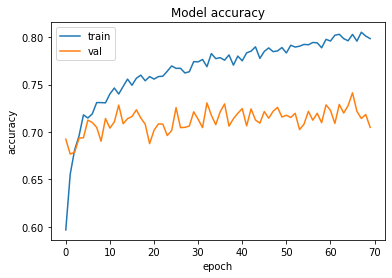

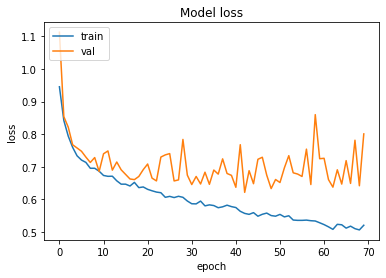

In [60]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
test_generator = generator(path_test, y_test, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE)
final_model.evaluate_generator(test_generator,30)

[0.7906650364398956, 0.7114583]

In [70]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(final_model.predict_classes(X))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

AttributeError: 'Model' object has no attribute 'predict_classes'

In [71]:
cm = confusion_matrix(Y_true, Y_pred)

In [72]:
cm

array([], shape=(0, 0), dtype=int64)

In [64]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

NameError: name 'classification_report' is not defined

## Culture vs no culture

In [9]:
IMAGES_DIR = 'images'

culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

In [10]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_no_culture = [1]*len(path_no_culture)

In [11]:
BATCH_SIZE = 64

file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25, random_state=42)
train_generator = generator(path_train, y_train, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE)
test_generator = generator(path_test, y_test, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE)

In [14]:
# Add new layer to pre-trained network
flat1 = Flatten()(source_model.layers[-3].output)
dropout_flatten = Dropout(0.5)(flat1)

dense256 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
dropout256 = Dropout(0.5)(dense256)

dense32 = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout256)
dropout32 = Dropout(0.5)(dense32)

output = Dense(1, activation='sigmoid')(dropout32)

model_culture = Model(inputs=base_model.input, outputs=output)

In [15]:
model_culture.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

conv5_block32_0_bn (BatchNormal (None, 2, 2, 1888)   7552        conv5_block31_concat[0][0]       
__________________________________________________________________________________________________
conv5_block32_0_relu (Activatio (None, 2, 2, 1888)   0           conv5_block32_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block32_1_conv (Conv2D)   (None, 2, 2, 128)    241664      conv5_block32_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block32_1_bn (BatchNormal (None, 2, 2, 128)    512         conv5_block32_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block32_1_relu (Activatio (None, 2, 2, 128)    0           conv5_block32_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

In [16]:
RUN_NAME = 'transfer_learning_culture2'
LOGS_PATH = 'logs'
#os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [17]:
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 2

model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=70,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 174 steps, validate for 58 steps
Epoch 1/70
174/174 [==============================] - 228s 1s/step - loss: 0.8260 - accuracy: 0.5138 - val_loss: 0.7450 - val_accuracy: 0.6401
Epoch 2/70
174/174 [==============================] - 206s 1s/step - loss: 0.7783 - accuracy: 0.5440 - val_loss: 0.7180 - val_accuracy: 0.6851
Epoch 3/70
174/174 [==============================] - 204s 1s/step - loss: 0.7524 - accuracy: 0.5626 - val_loss: 0.7068 - val_accuracy: 0.6765
Epoch 4/70
174/174 [==============================] - 204s 1s/step - loss: 0.7302 - accuracy: 0.5838 - val_loss: 0.6940 - val_accuracy: 0.6851
Epoch 5/70
174/174 [==============================] - 203s 1s/step - loss: 0.7152 - accuracy: 0.6018 - val_loss: 0.6749 - val_accuracy: 0.7072
Epoch 6/70
174/174 [==============================] - 203s 1s/step - loss: 0.6995 - accuracy: 0.6166 - val_loss: 0.6692 - val_accuracy: 0.7120
Epoch 7/70
174/174 [==============================] - 203s 1s/step - loss: 0.6966 - accuracy: 0.624

In [28]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.npy'),history.history)

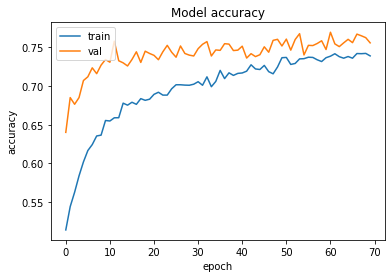

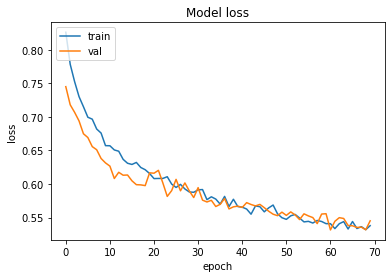

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
test_generator = generator(path_test, y_test, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE)
model_culture.evaluate_generator(test_generator,30)

[0.5505204766988754, 0.7609375]

# Change input

In [51]:
high_resolution_bands = [1,2,3,4,5,6,7,8,11,12]
eurosat_mean = [1116.468, 1041.475, 945.344, 1198.498, 2004.878, 2376.699, 2303.738, 732.957, 1116.271, 2602.579]
eurosat_std = [154.008, 187.997, 278.508, 228.122, 356.598, 456.035, 531.570, 98.947, 303.851, 503.181]

In [52]:
def generator_bands(paths, classes, eurosat_mean, eurosat_std, bands, batch_size=32, is_data_augmentation=True):
    
    while True : 
        random_indexs = random.sample(range(0,len(paths)), batch_size)
        batch_paths = paths[random_indexs]

        X = []
        Y = classes[random_indexs]

        for p in batch_paths:
            img = rasterio.open(p).read()[bands,:,:]
            img = np.float32(np.moveaxis(img, 0, -1))

            img = normalize(img, eurosat_mean, eurosat_std)
            
            if is_data_augmentation:
                
                # Angle rotation of 90, 180 or 270
                nb_rotation = random.randint(0,3)
                if nb_rotation != 0:
                    img = np.rot90(img,nb_rotation)
                    
                # Image flip
                if random.choice([True, False]):
                    img = np.flipud(img)
                    
                if random.choice([True, False]):
                    img = np.fliplr(img)
                
            X.append(img)
             
        X = np.asarray(X)
        yield (X,Y)

In [4]:
base_model = DenseNet(include_top=False,
                          weights=None,
                          input_shape=(64, 64, 13))

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
predictions = Dense(10, activation='softmax')(top_model)
source_model = Model(inputs=base_model.input, outputs=predictions)
source_model.load_weights("TransferLearning/dense_ms_from_scratch.209-0.990.hdf5")

C:\Users\romain.capocasa\.conda\envs\keras_gpu\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  str(input_shape[-1]) + ' input channels.')


In [17]:
import tensorflow

In [25]:
def change_model(model, new_input_shape=(None, 40, 40, 3),custom_objects=None):
    # replace input shape of first layer
    
    config = model.layers[0].get_config()
    config['batch_input_shape']=new_input_shape
    model._layers[0]=model.layers[0].from_config(config)

    # rebuild model architecture by exporting and importing via json
    new_model = tensorflow.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model._layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [26]:
new_model = change_model(source_model, new_input_shape=(None, 64,64,10))
new_model.summary()

Loaded layer input_1
Loaded layer zero_padding2d
Could not transfer weights for layer conv1/conv
Loaded layer conv1/bn
Loaded layer conv1/relu
Loaded layer zero_padding2d_1
Loaded layer pool1
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_0_relu
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_concat
Loaded layer conv2_block2_0_bn
Loaded layer conv2_block2_0_relu
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_concat
Loaded layer conv2_block3_0_bn
Loaded layer conv2_block3_0_relu
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded layer conv2_block3_concat
Loaded layer conv2_block4_0_bn
Loaded layer conv2_block4_0_relu
Loaded layer conv2_block4_1_conv
Loaded layer conv2_block4_1_bn

Loaded layer conv4_block25_concat
Loaded layer conv4_block26_0_bn
Loaded layer conv4_block26_0_relu
Loaded layer conv4_block26_1_conv
Loaded layer conv4_block26_1_bn
Loaded layer conv4_block26_1_relu
Loaded layer conv4_block26_2_conv
Loaded layer conv4_block26_concat
Loaded layer conv4_block27_0_bn
Loaded layer conv4_block27_0_relu
Loaded layer conv4_block27_1_conv
Loaded layer conv4_block27_1_bn
Loaded layer conv4_block27_1_relu
Loaded layer conv4_block27_2_conv
Loaded layer conv4_block27_concat
Loaded layer conv4_block28_0_bn
Loaded layer conv4_block28_0_relu
Loaded layer conv4_block28_1_conv
Loaded layer conv4_block28_1_bn
Loaded layer conv4_block28_1_relu
Loaded layer conv4_block28_2_conv
Loaded layer conv4_block28_concat
Loaded layer conv4_block29_0_bn
Loaded layer conv4_block29_0_relu
Loaded layer conv4_block29_1_conv
Loaded layer conv4_block29_1_bn
Loaded layer conv4_block29_1_relu
Loaded layer conv4_block29_2_conv
Loaded layer conv4_block29_concat
Loaded layer conv4_block30_0_b

Loaded layer conv5_block20_0_relu
Loaded layer conv5_block20_1_conv
Loaded layer conv5_block20_1_bn
Loaded layer conv5_block20_1_relu
Loaded layer conv5_block20_2_conv
Loaded layer conv5_block20_concat
Loaded layer conv5_block21_0_bn
Loaded layer conv5_block21_0_relu
Loaded layer conv5_block21_1_conv
Loaded layer conv5_block21_1_bn
Loaded layer conv5_block21_1_relu
Loaded layer conv5_block21_2_conv
Loaded layer conv5_block21_concat
Loaded layer conv5_block22_0_bn
Loaded layer conv5_block22_0_relu
Loaded layer conv5_block22_1_conv
Loaded layer conv5_block22_1_bn
Loaded layer conv5_block22_1_relu
Loaded layer conv5_block22_2_conv
Loaded layer conv5_block22_concat
Loaded layer conv5_block23_0_bn
Loaded layer conv5_block23_0_relu
Loaded layer conv5_block23_1_conv
Loaded layer conv5_block23_1_bn
Loaded layer conv5_block23_1_relu
Loaded layer conv5_block23_2_conv
Loaded layer conv5_block23_concat
Loaded layer conv5_block24_0_bn
Loaded layer conv5_block24_0_relu
Loaded layer conv5_block24_1_c

conv4_block38_1_conv (Conv2D)   (None, 4, 4, 128)    184320      conv4_block38_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block38_1_bn (BatchNormal (None, 4, 4, 128)    512         conv4_block38_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block38_1_relu (Activatio (None, 4, 4, 128)    0           conv4_block38_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block38_2_conv (Conv2D)   (None, 4, 4, 32)     36864       conv4_block38_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block38_concat (Concatena (None, 4, 4, 1472)   0           conv4_block37_concat[0][0]       
                                                                 conv4_block38_2_conv[0][0]       
__________

In [29]:
for k,v in new_model._get_trainable_state().items():
    k.trainable = False

In [35]:
# Add new layer to pre-trained network
flat1 = Flatten()(new_model.layers[-3].output)
dropout_flatten = Dropout(0.5)(flat1)

dense256 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
dropout256 = Dropout(0.5)(dense256)

dense32 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout256)
dropout32 = Dropout(0.5)(dense32)

output = Dense(1, activation='sigmoid')(dropout32)

final_model = Model(inputs=new_model.input, outputs=output)

In [36]:
IMAGES_DIR = 'images'
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
class1 = [0]*len(path1)

In [37]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
    
class2 = [1]*len(path2)

In [38]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)

In [53]:
BATCH_SIZE = 64

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.33, random_state=42)
train_generator = generator_bands(path_train, y_train, eurosat_mean, eurosat_std, bands=high_resolution_bands, batch_size=BATCH_SIZE, is_data_augmentation=True)
test_generator = generator_bands(path_test, y_test, eurosat_mean, eurosat_std, bands=high_resolution_bands,batch_size=BATCH_SIZE, is_data_augmentation=True)

In [54]:
RUN_NAME = 'highres'
LOGS_PATH = 'logs'


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [55]:
LEARNING_RATE = 0.00005
DATA_AUGMENTATION_MULTIPLIATOR = 3

final_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = final_model.fit(train_generator,
                        epochs=70,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 123 steps, validate for 60 steps
Epoch 1/70
123/123 [==============================] - 193s 2s/step - loss: 1.0113 - accuracy: 0.5370 - val_loss: 0.9641 - val_accuracy: 0.4682
Epoch 2/70
123/123 [==============================] - 163s 1s/step - loss: 0.9043 - accuracy: 0.5897 - val_loss: 0.9483 - val_accuracy: 0.4776
Epoch 3/70
123/123 [==============================] - 156s 1s/step - loss: 0.8611 - accuracy: 0.6165 - val_loss: 0.9467 - val_accuracy: 0.4732
Epoch 4/70
123/123 [==============================] - 168s 1s/step - loss: 0.8253 - accuracy: 0.6293 - val_loss: 0.9508 - val_accuracy: 0.4773
Epoch 5/70
123/123 [==============================] - 218s 2s/step - loss: 0.7960 - accuracy: 0.6494 - val_loss: 0.9589 - val_accuracy: 0.4651
Epoch 6/70
123/123 [==============================] - 217s 2s/step - loss: 0.7919 - accuracy: 0.6578 - val_loss: 0.9231 - val_accuracy: 0.4763
Epoch 7/70
123/123 [==============================] - 215s 2s/step - loss: 0.7742 - accuracy: 0.661

In [58]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, RUN_NAME))

final_model.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.npy'),history.history)

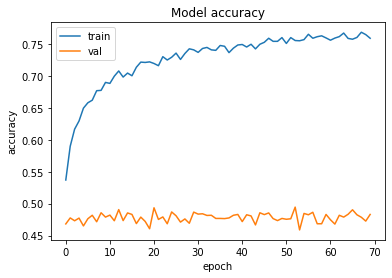

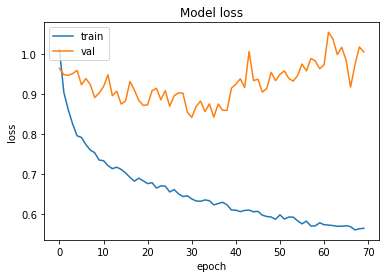

In [59]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
